### Table of Contents

1. [Logistic Regression](#chapter1)
    1. [Loading dataset](#section_1_1)
    2. [Data Cleaning](#section_1_2)
    3. [Features](#section_1_2_1)
    4. [Preprocessing](#section_1_2_2)
    5. [Statsmodel Logistic Regresion](#section_1_2_3)
    6. [Scikit Learn Logistic Regresion](#section_1_2_4)
        1. [Manual Calculation of P-value](#section_1_2_5)
2. [Glmnet, Ridge, and Lasso Regression](#2)
    1. [Ridge Regression](#21)
    2. [Glmnet ElasticNet Regression](#21)
    3. [Lasso Regression](#23)

# Logistic Regression and Feature Selection of Home Credit Default Risk  <a class="anchor" id="chapter1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
import seaborn as sns
from sklearn.model_selection import train_test_split

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score, roc_curve, auc
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline

### Loading dataset from LightGBM aggregations + feature engineering  <a class="anchor" id="section_1_1"></a>
Shape: {356251, 492}
Training data: {307507, 492}
Testing data: {48744, 492}

In [2]:
tt=pd.read_csv('o_full_train')

### Data Cleaning <a class="anchor" id="section_1_2"></a>
Removing columns with large number of missing values, imputing NA's with median

In [3]:
def remove_missing_columns(train, test, threshold = 90):
    # Calculate missing stats for train and test (remember to calculate a percent!)
    train_miss = pd.DataFrame(train.isnull().sum())
    train_miss['percent'] = 100 * train_miss[0] / len(train)
    
    test_miss = pd.DataFrame(test.isnull().sum())
    test_miss['percent'] = 100 * test_miss[0] / len(test)
    
    # list of missing columns for train and test
    missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])
    missing_test_columns = list(test_miss.index[test_miss['percent'] > threshold])
    
    # Combine the two lists together
    missing_columns = list(set(missing_train_columns + missing_test_columns))
    
    # Print information
    print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
    
    # Drop the missing columns and return
    train = train.drop(columns = missing_columns)
    test = test.drop(columns = missing_columns)
    
    return train, test

In [4]:
# splitting training and test data
train= tt[tt['TARGET'].notnull()]
test = tt[tt['TARGET'].isnull()]
ttarget=test['TARGET']
target = train['TARGET']

In [5]:
train, test = remove_missing_columns(train,test)
train['TARGET']=target

There are 27 columns with greater than 90% missing values.


In [6]:
# getting rid of infinity values
train=train.replace([np.inf, -np.inf], np.nan)
test=test.replace([np.inf, -np.inf], np.nan)

In [7]:
# imputing median
train.fillna(train.median(),inplace=True)
test.fillna(test.median(),inplace=True)
test['TARGET']=ttarget

### Features <a class="anchor" id="section_1_2_1"></a>
- Features taken from Top 100 in gain feature importance from LightGBM model (ROC AUC Local CV: 0.8005): *insert link here*
- Commented out features with large p-values after statsmodels logistic regression analysis (p>0.005) but with interesting interaction with other more important features (different from deleted list below)

In [8]:
#collinear removal (corr + vif)
feature_cols=['prev_score_mean', 'prev_score_max','EXT_SOURCE_2', 'buro_score_mean', 'EXT_SOURCE_3',
       'buro_score_sum', 'external_1_refill', 'INTEREST',
       'app EXT_SOURCE_1 / DAYS_BIRTH', 'buro_score_recent2y_sum',
       'app EXT_SOURCE_1 * EXT_SOURCE_2', 'app EXT_SOURCE_3 / DAYS_BIRTH',
       'prev_score_last', 'DAYS_EMPLOYED', 'DOWN_PAYMENT',
       'NEW_CREDIT_TO_ANNUITY_RATIO/3', 'NEW_CREDIT_TO_ANNUITY_RATIO',
       'buro_score_max', 'AMT_ANNUITY', 'CNT_PAYMENT',
       'app EXT_SOURCE_1 * EXT_SOURCE_3', 'DAYS_BIRTH', 'LATE_PAYMENT',
       'EXT_SOURCE_1', 'BURO_AMT_CREDIT_DEBT_RATE_MAX',
       'INSTAL_AMT_INSTALMENT_SUM', 'CRED_UTIL_2', 'prev_score_var',
       'CODE_GENDER', 'external_3_refill', 'DAYS_ID_PUBLISH',
       'NEW_CREDIT_TO_GOODS_RATIO', 'BURO_AMT_CREDIT_DEBT_RATE_VAR',
       'PREV_days_late_due_MEAN', 'buro_score_last',
       'NEW_ANNUITY_TO_INCOME_RATIO', 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
       'REGION_POPULATION_RELATIVE', 'NEW_CAR_TO_EMPLOY_RATIO',
       'POS_MONTHS_BALANCE_MEAN', 'INTEREST_SHARE', 'buro_score_var',
       'OWN_CAR_AGE', 'CLOSED_DAYS_CREDIT_MAX',
       'NAME_EDUCATION_TYPE_Higher education', 'POS_COUNT',
       'PREV_days_late_due_MIN', 'APPROVED_DAYS_DECISION_MAX',
       'NEW_SCORES_STD', 'INSTAL_DPD_MEAN', 'NEW_PHONE_TO_EMPLOY_RATIO',
       '60_DAYSAMT_PAYMENT_MIN', 'POS_MONTHS_BALANCE_MAX', 'DAYS_REGISTRATION',
       'BURO_AMT_CREDIT_SUM_SUM', 'ACTIVE_AMT_CREDIT_SUM_MEAN',
       'CLOSED_DAYS_CREDIT_ENDDATE_MAX', 'ACTIVE_AMT_CREDIT_SUM_MAX',
       '60_DAYSAMT_INSTALMENT_MAX', 'ACTIVE_DAYS_CREDIT_MAX',
       'PREV_DAYS_DECISION_MEAN', 'PREV_DAYS_DECISION_MAX',
       'DAYS_LAST_PHONE_CHANGE', 'BURO_DAYS_CREDIT_ENDDATE_MAX',
       'INSTAL_DBD_SUM', 'BURO_DAYS_CREDIT_MAX', 'NAME_FAMILY_STATUS_Married',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'NEW_RATIO_BURO_AMT_CREDIT_SUM_MAX', 'NEW_RATIO_BURO_DAYS_CREDIT_MAX',
       'prev_score_recent2y_sum', 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
       'ACTIVE_DAYS_CREDIT_ENDDATE_MIN', 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
       'INSTAL_AMT_INSTALMENT_MEAN', 'APARTMENTS_AVG',
       'ACTIVE_DAYS_CREDIT_UPDATE_MEAN',
       'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MAX',
       'YEARS_BEGINEXPLUATATION_AVG', 'INSTAL_DAYS_ENTRY_PAYMENT_SUM',
       'INSTAL_AMT_INSTALMENT_MAX', 'ACTIVE_AMT_CREDIT_DEBT_RATE_SUM',
       'INSTAL_AMT_PAYMENT_MIN', 'INSTAL_DBD_MEAN', 'PREV_CNT_PAYMENT_MEAN',
       'PREV_APP_CREDIT_PERC_VAR', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'PREV_APP_CREDIT_PERC_MAX', 'INSTAL_PAYMENT_DIFF_MEAN',
       '60_DAYSDAYS_ENTRY_PAYMENT_MEAN', 'APPROVED_AMT_APPLICATION_MAX',
       'PREV_AMT_DOWN_PAYMENT_MAX']

In [9]:
#top 200
feature_cols=['NEW_EXT_SOURCES_MEAN', 'prev_score_mean',
       'app EXT_SOURCE_2 * EXT_SOURCE_3', 'buro_score_sum', 'prev_score_max',
       'buro_score_mean', 'external_1_refill', 'EXT_SOURCE_2', 'INTEREST',
       'app EXT_SOURCE_2 * DAYS_EMPLOYED', 'buro_score_max', 'prev_score_last',
       'app EXT_SOURCE_1 / DAYS_BIRTH', 'DOWN_PAYMENT', 'EXT_SOURCE_3',
       'buro_score_recent2y_sum', 'app EXT_SOURCE_1 * EXT_SOURCE_2',
       'NEW_CREDIT_TO_ANNUITY_RATIO', 'CNT_PAYMENT', 'AMT_ANNUITY',
       'app EXT_SOURCE_2 / DAYS_BIRTH', 'DAYS_BIRTH', 'LATE_PAYMENT',
       'app EXT_SOURCE_3 / DAYS_BIRTH', 'CRED_UTIL_2',
       'ACTIVE_AMT_CREDIT_DEBT_RATE_MAX', 'external_3_refill', 'CODE_GENDER',
       'AMT_CREDIT', 'NEW_CREDIT_TO_GOODS_RATIO',
       'NEW_CREDIT_TO_ANNUITY_RATIO/3', 'NEW_SOURCES_PROD', 'DAYS_ID_PUBLISH',
       'INSTAL_AMT_PAYMENT_SUM', 'app EXT_SOURCE_3 * DAYS_EMPLOYED',
       'NAME_EDUCATION_TYPE_Higher education', 'NEW_ANNUITY_TO_INCOME_RATIO',
       'NEW_EMPLOY_TO_BIRTH_RATIO', 'INTEREST_SHARE', 'EXT_SOURCE_1',
       'buro_score_var', 'REGION_POPULATION_RELATIVE', 'AMT_GOODS_PRICE',
       'DAYS_EMPLOYED', 'POS_MONTHS_BALANCE_MAX', 'AGE_INT',
       'CLOSED_DAYS_CREDIT_MAX', 'prev_score_var',
       'BURO_AMT_CREDIT_DEBT_RATE_VAR', 'app EXT_SOURCE_1 * EXT_SOURCE_3',
       'OWN_CAR_AGE', 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
       'ACTIVE_AMT_CREDIT_SUM_SUM', 'POS_MONTHS_BALANCE_MEAN',
       'INSTAL_AMT_INSTALMENT_SUM',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'NEW_CAR_TO_BIRTH_RATIO', 'APPROVED_DAYS_DECISION_MAX',
       'INSTAL_DPD_MEAN', 'buro_score_last', 'POS_COUNT', 'DAYS_REGISTRATION',
       'CLOSED_DAYS_CREDIT_ENDDATE_MAX', 'BURO_AMT_CREDIT_DEBT_RATE_MAX',
       'ACTIVE_DAYS_CREDIT_MAX', 'PREV_DAYS_DECISION_MAX',
       'NAME_FAMILY_STATUS_Married', 'PREV_length_of_loan_MEAN',
       'BURO_DAYS_CREDIT_ENDDATE_MAX', 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
       'NEW_CAR_TO_EMPLOY_RATIO', 'INSTAL_AMT_PAYMENT_MIN',
       'NEW_CREDIT_TO_INCOME_RATIO', 'PREV_days_late_due_MEAN',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'NEW_PHONE_TO_EMPLOY_RATIO',
       'ACTIVE_AMT_CREDIT_SUM_MAX', 'prev_score_recent2y_sum',
       'NEW_PHONE_TO_BIRTH_RATIO', 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN',
       'NEW_RATIO_BURO_DAYS_CREDIT_MAX', '60_DAYSAMT_PAYMENT_MIN',
       'INSTAL_DBD_SUM', 'APPROVED_DAYS_DECISION_MEAN', 'BURO_DAYS_CREDIT_MAX',
       'ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN', 'DAYS_LAST_PHONE_CHANGE',
       'ACTIVE_AMT_CREDIT_DEBT_RATE_MEAN', 'ACTIVE_AMT_CREDIT_SUM_MEAN',
       'BURO_AMT_CREDIT_SUM_DEBT_MEAN', 'PREV_days_late_due_MIN',
       'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN', 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
       'PREV_DAYS_DECISION_MEAN', 'INSTAL_PAYMENT_DIFF_MEAN',
       'BURO_AMT_CREDIT_SUM_SUM', 'INSTAL_DBD_MEAN', 'NEW_DOC_IND_KURT',
       'INSTAL_AMT_PAYMENT_MEAN', 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN']

In [10]:
#spearman rank hierarchy feature reduction with inconsistency level 2
feature_cols=['NEW_EXT_SOURCES_MEAN',
 'prev_score_mean',
 'buro_score_sum',
 'prev_score_max',
 'external_1_refill',
 'EXT_SOURCE_2',
 'INTEREST',
 'app EXT_SOURCE_2 * DAYS_EMPLOYED',
 'buro_score_max',
 'app EXT_SOURCE_1 / DAYS_BIRTH',
 'DOWN_PAYMENT',
 'app EXT_SOURCE_1 * EXT_SOURCE_2',
 'NEW_CREDIT_TO_ANNUITY_RATIO',
 'AMT_ANNUITY',
 'app EXT_SOURCE_2 / DAYS_BIRTH',
 'DAYS_BIRTH',
 'LATE_PAYMENT',
 'app EXT_SOURCE_3 / DAYS_BIRTH',
 'CRED_UTIL_2',
 'ACTIVE_AMT_CREDIT_DEBT_RATE_MAX',
 'external_3_refill',
 'NEW_CREDIT_TO_GOODS_RATIO',
 'DAYS_ID_PUBLISH',
 'INSTAL_AMT_PAYMENT_SUM',
 'NAME_EDUCATION_TYPE_Higher education',
 'NEW_ANNUITY_TO_INCOME_RATIO',
 'NEW_EMPLOY_TO_BIRTH_RATIO',
 'POS_MONTHS_BALANCE_MAX',
 'CLOSED_DAYS_CREDIT_MAX',
 'OWN_CAR_AGE',
 'ACTIVE_AMT_CREDIT_SUM_SUM',
 'POS_MONTHS_BALANCE_MEAN',
 'NEW_CAR_TO_BIRTH_RATIO',
 'INSTAL_DPD_MEAN',
 'POS_COUNT',
 'ACTIVE_DAYS_CREDIT_MAX',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'INSTAL_AMT_PAYMENT_MIN',
 'NEW_PHONE_TO_EMPLOY_RATIO',
 'NEW_RATIO_BURO_DAYS_CREDIT_MAX',
 '60_DAYSAMT_PAYMENT_MIN',
 'DAYS_LAST_PHONE_CHANGE',
 'ACTIVE_AMT_CREDIT_DEBT_RATE_MEAN',
 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
 'INSTAL_PAYMENT_DIFF_MEAN',
 'BURO_AMT_CREDIT_SUM_SUM',
   'INSTAL_AMT_PAYMENT_MEAN',
   'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
   'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MAX',
   'ACTIVE_AMT_CREDIT_DEBT_RATE_VAR',
  'INSTAL_DBD_MAX',
  'prev_score_sum',
  'POS_NAME_CONTRACT_STATUS_Active_MEAN',
  'PREV_APP_CREDIT_PERC_VAR', 
  'CLOSED_DAYS_CREDIT_VAR',
 'CLOSED_AMT_CREDIT_SUM_SUM',
  'BURO_DAYS_CREDIT_MEAN',
 'NEW_RATIO_BURO_DAYS_CREDIT_ENDDATE_MAX',
 'APPROVED_AMT_DOWN_PAYMENT_MAX',
 'ACTIVE_DAYS_CREDIT_MEAN',
 'APPROVED_INTEREST_SHARE_PREV_MEAN',
 'INSTAL_DAYS_ENTRY_PAYMENT_SUM',
 'NEW_INC_PER_CHLD',
 'APPROVED_INTEREST_PREV_MAX',
 'CLOSED_MONTHS_BALANCE_SIZE_MEAN',
 'POS_NAME_CONTRACT_STATUS_Completed_MEAN',
 'APPROVED_AMT_ANNUITY_MIN',
 'PREV_HOUR_APPR_PROCESS_START_MEAN',
 '60_DAYSAMT_INSTALMENT_SUM',
 'APPROVED_APP_CREDIT_PERC_MIN',
 'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MIN']
             

In [11]:
# features with p<0.05 deleted after statsmodel logistic run
feature_cols=['NEW_EXT_SOURCES_MEAN',
 'prev_score_mean',
 'buro_score_sum',
 'prev_score_max',
 'external_1_refill',
 'INTEREST',
 'buro_score_max',
 'app EXT_SOURCE_1 / DAYS_BIRTH',
 'DOWN_PAYMENT',
 'app EXT_SOURCE_1 * EXT_SOURCE_2',
 'NEW_CREDIT_TO_ANNUITY_RATIO',
 'AMT_ANNUITY',
 'app EXT_SOURCE_2 / DAYS_BIRTH',
 'DAYS_BIRTH',
 'LATE_PAYMENT',
 'app EXT_SOURCE_3 / DAYS_BIRTH',
 'CRED_UTIL_2',
 'external_3_refill',
 'NEW_CREDIT_TO_GOODS_RATIO',
 'DAYS_ID_PUBLISH',
 'INSTAL_AMT_PAYMENT_SUM',
 'NAME_EDUCATION_TYPE_Higher education',
 'NEW_ANNUITY_TO_INCOME_RATIO',
 'NEW_EMPLOY_TO_BIRTH_RATIO',
 'POS_MONTHS_BALANCE_MAX',
 'CLOSED_DAYS_CREDIT_MAX',
 'OWN_CAR_AGE',
 'ACTIVE_AMT_CREDIT_SUM_SUM',
 'POS_MONTHS_BALANCE_MEAN',
 'NEW_CAR_TO_BIRTH_RATIO',
 'POS_COUNT',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'NEW_RATIO_BURO_DAYS_CREDIT_MAX',
 'INSTAL_PAYMENT_DIFF_MEAN',
 'BURO_AMT_CREDIT_SUM_SUM',
 'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MAX',
 'INSTAL_DBD_MAX',
 'prev_score_sum',
 'POS_NAME_CONTRACT_STATUS_Active_MEAN',
 'CLOSED_AMT_CREDIT_SUM_SUM',
 'APPROVED_INTEREST_SHARE_PREV_MEAN',
 'NEW_INC_PER_CHLD',
 'CLOSED_MONTHS_BALANCE_SIZE_MEAN',
 'POS_NAME_CONTRACT_STATUS_Completed_MEAN',
 'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MIN']

In [12]:
len(feature_cols)

45

#### Deleted Features (large p-value after statsmodels logistic regression analysis)
['NEW_SCORES_STD',
       'NEW_CREDIT_TO_INCOME_RATIO', 'BURO_AMT_CREDIT_DEBT_RATE_MAX',
       'NEW_RATIO_BURO_AMT_CREDIT_SUM_MEAN', 'BURO_AMT_CREDIT_SUM_SUM',
       'INSTAL_PAYMENT_DIFF_MEAN', 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
       'NEW_RATIO_BURO_DAYS_CREDIT_MAX',
       'POS_NAME_CONTRACT_STATUS_Active_MEAN', 'INSTAL_DBD_SUM',
       'PREV_APP_CREDIT_PERC_VAR', 'NEW_CAR_TO_EMPLOY_RATIO',
       'BURO_DAYS_CREDIT_MAX', 'INSTAL_PAYMENT_PERC_SUM',
       'INSTAL_DAYS_ENTRY_PAYMENT_MEAN', 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN',
       'ACTIVE_AMT_CREDIT_DEBT_RATE_VAR', 'APPROVED_INTEREST_SHARE_MEAN',
       'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MAX', 'NEW_PHONE_TO_BIRTH_RATIO', 'INSTAL_AMT_INSTALMENT_SUM',
       'NEW_DOC_IND_KURT', 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
       'PREV_DAYS_DECISION_MEAN', 'PREV_DAYS_DECISION_MAX',
       'APPROVED_AMT_DOWN_PAYMENT_MAX', 'NEW_SOURCES_PROD',
       'APPROVED_DAYS_DECISION_MEAN', 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN',]

### Preprocessing <a class="anchor" id="section_1_2_2"></a>
- Separated training and test data
- Scaled training data (BIG improvement in ROC AUC - from 0.51 to 0.78)

In [13]:
#feature_cols = [f for f in train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index','Unnamed: 0']]

#main training set
y = train.TARGET
X = train[feature_cols]

#for use in later regressions
y1=train.TARGET 
X1=train[feature_cols]
y2=train.TARGET 
X2=train[feature_cols]

#test set
X_test=test[feature_cols]
y_test=test.TARGET

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(X)
scaled_train = scaler.transform(X)
scaler.fit(X1)
scaled_train1 = scaler.transform(X1)
X = pd.DataFrame(scaled_train, index=X.index, columns=X.columns)
X1 = pd.DataFrame(scaled_train1, index=X1.index, columns=X1.columns)

### Statsmodel Logistic Regression <a class="anchor" id="section_1_2_3"></a>
Determining p-values for coefficients to help with feature selection as well as provide another dimension of feature importance

In [14]:
X_train = sm.add_constant(X1)
est1 = sm.Logit(y, X_train).fit()
stats=pd.DataFrame()
stats=est1.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.239943
         Iterations 11


In [15]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:100].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LR Features (avg over folds)')
    plt.tight_layout
    plt.savefig('lr_importances01.png')

In [16]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index):
    y_predict = model.predict_proba(X1.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y1.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

In [17]:
stats_html = stats.as_html()
stats=pd.read_html(stats_html, header=0, index_col=0)[0]

In [18]:
stats=stats.rename(columns={'P>|z|': 'pval'})
stats.head(60) #first 50

,coef,std err,z,pval,[0.025,0.975]
const,-8.0937,0.905,-8.947,0.000,-9.867,-6.321
NEW_EXT_SOURCES_MEAN,-1.9941,0.087,-22.999,0.000,-2.164,-1.824
prev_score_mean,3.1944,0.174,18.369,0.000,2.854,3.535
buro_score_sum,7.5580,0.532,14.213,0.000,6.516,8.600
prev_score_max,1.3191,0.146,9.065,0.000,1.034,1.604
external_1_refill,-2.1828,0.067,-32.585,0.000,-2.314,-2.052
INTEREST,0.0769,0.038,2.038,0.042,0.003,0.151
buro_score_max,1.7726,0.110,16.084,0.000,1.557,1.989
app EXT_SOURCE_1 / DAYS_BIRTH,1.0723,0.126,8.485,0.000,0.825,1.320
DOWN_PAYMENT,-1.3369,0.261,-5.116,0.000,-1.849,-0.825


In [19]:
updated_fc=stats[stats['pval']<=0.05]
updated_fc=list(updated_fc.index)
updated_fc

['const',
 'NEW_EXT_SOURCES_MEAN',
 'prev_score_mean',
 'buro_score_sum',
 'prev_score_max',
 'external_1_refill',
 'INTEREST',
 'buro_score_max',
 'app EXT_SOURCE_1 / DAYS_BIRTH',
 'DOWN_PAYMENT',
 'app EXT_SOURCE_1 * EXT_SOURCE_2',
 'NEW_CREDIT_TO_ANNUITY_RATIO',
 'AMT_ANNUITY',
 'app EXT_SOURCE_2 / DAYS_BIRTH',
 'DAYS_BIRTH',
 'LATE_PAYMENT',
 'app EXT_SOURCE_3 / DAYS_BIRTH',
 'CRED_UTIL_2',
 'external_3_refill',
 'NEW_CREDIT_TO_GOODS_RATIO',
 'DAYS_ID_PUBLISH',
 'INSTAL_AMT_PAYMENT_SUM',
 'NAME_EDUCATION_TYPE_Higher education',
 'NEW_ANNUITY_TO_INCOME_RATIO',
 'NEW_EMPLOY_TO_BIRTH_RATIO',
 'POS_MONTHS_BALANCE_MAX',
 'CLOSED_DAYS_CREDIT_MAX',
 'OWN_CAR_AGE',
 'ACTIVE_AMT_CREDIT_SUM_SUM',
 'NEW_CAR_TO_BIRTH_RATIO',
 'POS_COUNT',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'NEW_RATIO_BURO_DAYS_CREDIT_MAX',
 'INSTAL_PAYMENT_DIFF_MEAN',
 'BURO_AMT_CREDIT_SUM_SUM',
 'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MAX',
 'prev_score_sum',
 'POS_NAME_CONTRACT_STATUS_Active_MEAN',
 'CLOSED_AMT_CREDIT_SUM_SUM',


In [20]:
# cv = StratifiedKFold(n_splits=5, random_state=19, shuffle=True)
# results = pd.DataFrame(columns=['training_score', 'test_score'])
# fprs, tprs, scores = [], [], []
    
# for (train1, test1), i in zip(cv.split(X, y), range(5)):
#      model=sm.Logit(y, X_train).fit()
#     _, _, auc_score_train = compute_roc_auc(train1)
#     fpr, tpr, auc_score = compute_roc_auc(test1)
#     scores.append((auc_score_train, auc_score))
#     fprs.append(fpr)
#     tprs.append(tpr)
#     feature_importance_df = pd.DataFrame()
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["feature"] = feature_cols
#     fold_importance_df["importance"] = model.coef_[0]
    
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)


# display_importances(feature_importance_df)

# plot_roc_curve(fprs, tprs);
# pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

### Scikit Learn Logistic Regression <a class="anchor" id="section_1_2_4"></a>
Used newton-cg solver for best results

In [21]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(
    C=1,
    max_iter=200,
    solver='saga'
)

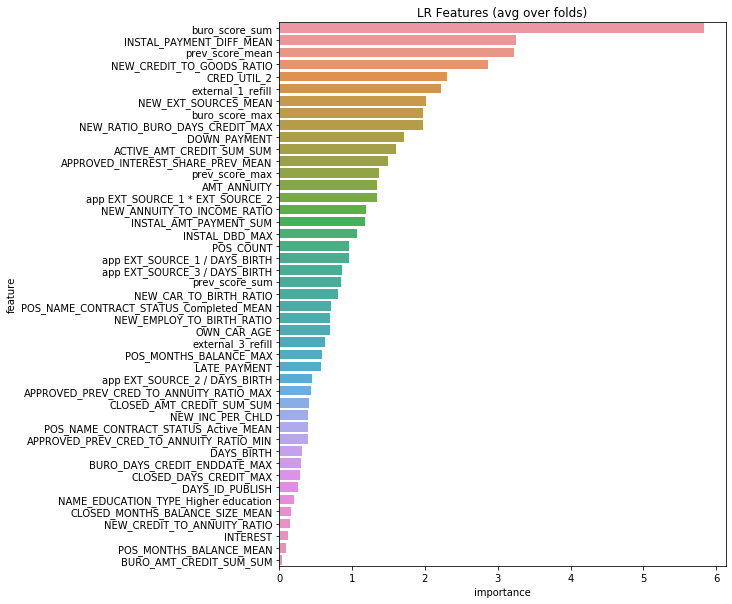

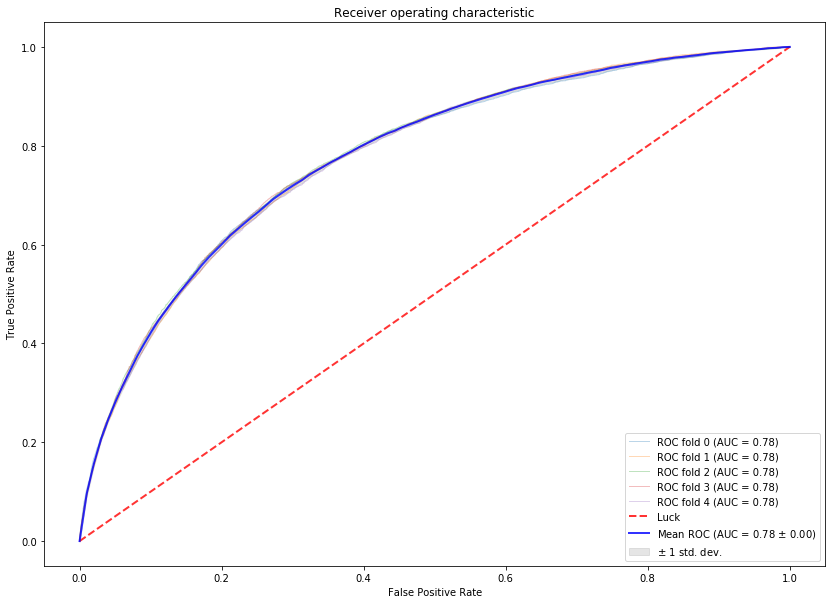

,AUC Train,AUC Test,f1-score
0,0.779281,0.777438,0.523489
1,0.778873,0.777936,0.518803
2,0.778309,0.781169,0.519103
3,0.778448,0.780607,0.522713
4,0.779678,0.775731,0.521334


In [22]:
cv = StratifiedKFold(n_splits=5, random_state=19, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
    
for (train1, test1), i in zip(cv.split(X1, y1), range(5)):
    model=clf.fit(X1.iloc[train1], y1.iloc[train1])
    _, _, auc_score_train = compute_roc_auc(train1)
    y_pred = model.predict(X1.iloc[test1])
    f1_test = f1_score(y1.iloc[test1],y_pred, average='macro',zero_division=1)
    fpr, tpr, auc_score = compute_roc_auc(test1)
    scores.append((auc_score_train, auc_score, f1_test))
    fprs.append(fpr)
    tprs.append(tpr)
    feature_importance_df = pd.DataFrame()
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feature_cols
    fold_importance_df["importance"] = abs(model.coef_[0])
    
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)


display_importances(feature_importance_df)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test','f1-score'])

#### Manual Calculation of P-Value for Sklearn LR <a class="anchor" id="section_1_2_5"></a>

In [23]:
from scipy.stats import norm

In [24]:
l1=['const']
l2=X.columns.tolist()
cols=l1+l2

Forked from https://stackoverflow.com/questions/25122999/scikit-learn-how-to-check-coefficients-significance

In [25]:
def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p

# test p-values
pvals=pd.DataFrame(logit_pvalue(clf, X),index=cols)

In [26]:
pvals.head(50)

,0
const,1.473209e-08
NEW_EXT_SOURCES_MEAN,0.000000e+00
prev_score_mean,0.000000e+00
buro_score_sum,0.000000e+00
prev_score_max,0.000000e+00
external_1_refill,0.000000e+00
INTEREST,1.363823e-03
buro_score_max,0.000000e+00
app EXT_SOURCE_1 / DAYS_BIRTH,3.996803e-14
DOWN_PAYMENT,4.811307e-11


### Linear Discriminant Analysis

In [27]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [28]:
lda = LinearDiscriminantAnalysis(solver='svd')
y_pred = lda.fit(X2, y2).predict(X2)

df_ = pd.DataFrame({'True default status': y2,
                    'Predicted default status': y_pred})
df_.replace(to_replace={0:'No', 1:'Yes'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status,No,Yes
Predicted default status,,
No,279322,22247
Yes,3360,2578


In [29]:
cm = confusion_matrix(y, y_pred)
print(cm.T)

[[279322  22247]
 [  3360   2578]]


In [30]:
def plot_confusion_matrix(cm, title='Confusion matrix (Normalized)',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized confusion matrix')
    plt.colorbar()
    plt.tight_layout()
    plt.xlabel('True label',rotation='horizontal', ha='right')
    plt.ylabel('Predicted label')
    plt.show()

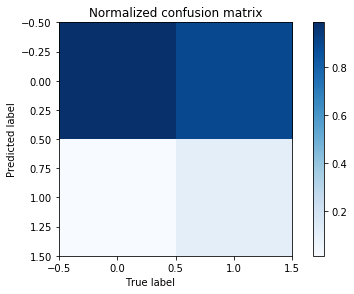

In [31]:
cm = confusion_matrix(y, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized.T)

In [32]:
print(classification_report(y2, y_pred, target_names=['No Default', 'Yes Default'], digits=3))

              precision    recall  f1-score   support

  No Default      0.926     0.988     0.956    282682
 Yes Default      0.434     0.104     0.168     24825

    accuracy                          0.917    307507
   macro avg      0.680     0.546     0.562    307507
weighted avg      0.887     0.917     0.893    307507



In [33]:
decision_prob = 0.5
y_prob = lda.fit(X2, y2).predict_proba(X2)

df_ = pd.DataFrame({'True default status': y2,
                    'Predicted default status': y_prob[:,1] > decision_prob})
df_.replace(to_replace={0:'No', 1:'Yes', 'True':'Yes', 'False':'No'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status,No,Yes
Predicted default status,,
No,279322,22247
Yes,3360,2578


In [34]:
# Check confusion matrix 
cm = confusion_matrix(y2, y_prob[:,1] > decision_prob)
print(cm.T)

[[279322  22247]
 [  3360   2578]]


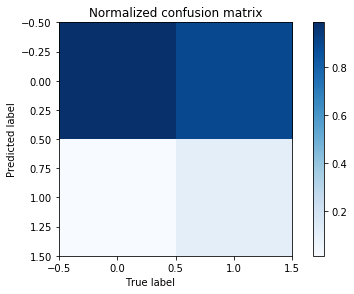

In [35]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized.T)

In [36]:
print(classification_report(y2, y_prob[:,1] > decision_prob, target_names=['No Default', 'Yes Default'], digits=3))

              precision    recall  f1-score   support

  No Default      0.926     0.988     0.956    282682
 Yes Default      0.434     0.104     0.168     24825

    accuracy                          0.917    307507
   macro avg      0.680     0.546     0.562    307507
weighted avg      0.887     0.917     0.893    307507



## Glmnet and Lasso Regression <a class="anchor" id="2"></a>

In [37]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import scale 
from sklearn.metrics import mean_squared_error
import glmnet as glm

### Glmnet Coefficients <a class="anchor" id="22"></a>

In [38]:
from sklearn.linear_model import ElasticNetCV

In [39]:
elnet = glm.ElasticNet(alpha=0.00012094930862976942, scoring='mean_squared_error')
elnet_orig = elnet.fit(X1, y1.to_numpy().ravel())
elnet.lambda_max_

0.0060474654314884545

#### Need to use logistic regression with penalty parameter because ElasticNet does "predict_proba" function needed to generate AUC/ROC

In [40]:
elnetlog = LogisticRegression(solver='saga', random_state=19, penalty='elasticnet',l1_ratio=0.6)
#elnet_model=elnetlog.fit(scale(X1), y1)

In [41]:
glmcv = ElasticNetCV(alphas=None, cv=5, max_iter=10000)
glmcv.fit(scale(X1), y1.to_numpy().ravel())

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
             l1_ratio=0.5, max_iter=10000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [42]:
glmcv.alpha_

0.00012094930862976942

In [43]:
elnet.lambda_best_

array([0.20745644])

In [44]:
pd.Series(elnet.coef_path_[:,elnet.lambda_max_inx_], index=X1.columns)

NEW_EXT_SOURCES_MEAN                      -0.123804
prev_score_mean                            0.295129
buro_score_sum                             1.091507
prev_score_max                             0.137331
external_1_refill                         -0.129003
INTEREST                                   0.001018
buro_score_max                             0.135551
app EXT_SOURCE_1 / DAYS_BIRTH              0.113426
DOWN_PAYMENT                              -0.041773
app EXT_SOURCE_1 * EXT_SOURCE_2           -0.003202
NEW_CREDIT_TO_ANNUITY_RATIO               -0.012297
AMT_ANNUITY                                0.111044
app EXT_SOURCE_2 / DAYS_BIRTH              0.112122
DAYS_BIRTH                                 0.028467
LATE_PAYMENT                              -0.062470
app EXT_SOURCE_3 / DAYS_BIRTH              0.071937
CRED_UTIL_2                                0.278381
external_3_refill                         -0.064350
NEW_CREDIT_TO_GOODS_RATIO                  0.358711
DAYS_ID_PUBL

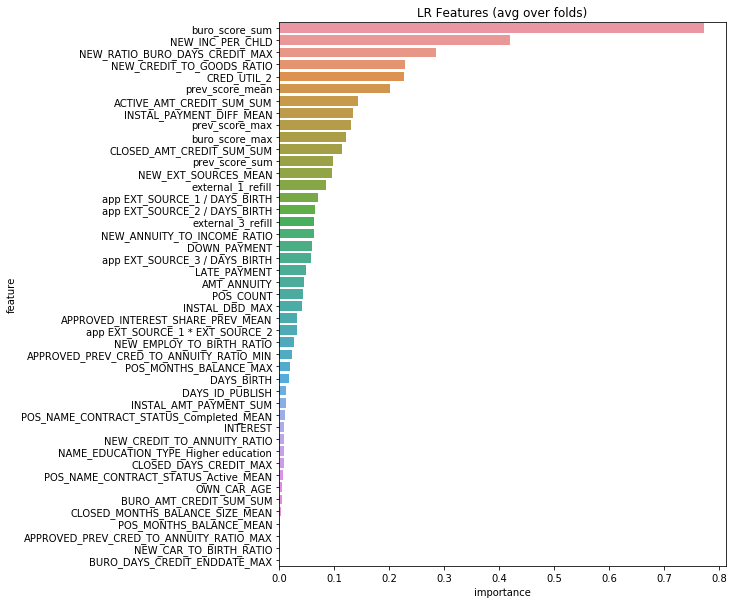

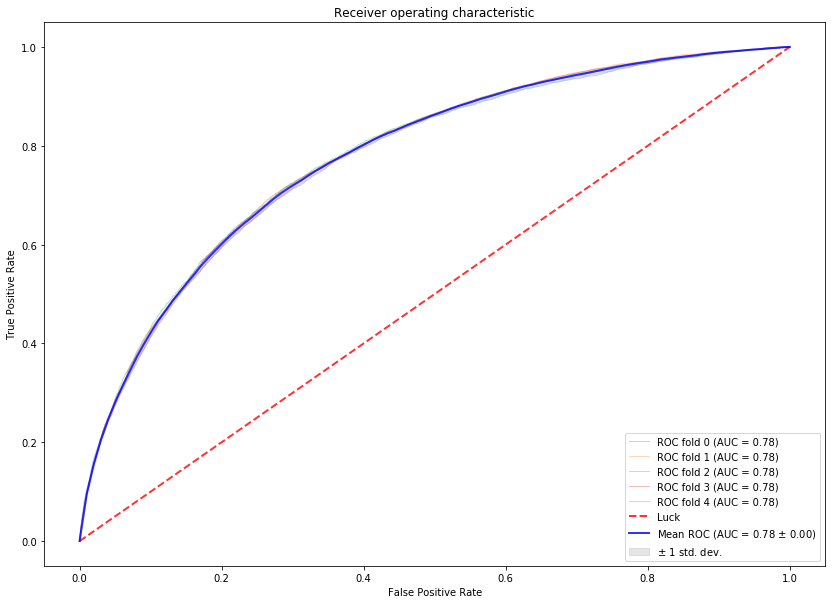

,AUC Train,AUC Test,f1-score
0,0.779490,0.777506,0.524044
1,0.779037,0.778168,0.519701
2,0.778482,0.781371,0.519080
3,0.778622,0.780801,0.522520
4,0.779862,0.775868,0.521841


In [45]:
cv = StratifiedKFold(n_splits=5, random_state=19, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
    
for (train1, test1), i in zip(cv.split(X1, y1), range(5)):
    model=elnetlog.fit(X1.iloc[train1], y1.iloc[train1])
    _, _, auc_score_train = compute_roc_auc(train1)
    y_pred = model.predict(X1.iloc[test1])
    f1_test = f1_score(y1.iloc[test1],y_pred, average='macro',zero_division=1)
    fpr, tpr, auc_score = compute_roc_auc(test1)
    scores.append((auc_score_train, auc_score, f1_test))
    fprs.append(fpr)
    tprs.append(tpr)
    feature_importance_df = pd.DataFrame()
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feature_cols
    fold_importance_df["importance"] = abs(elnet_orig.coef_)
    #model.coef_path_[:,ridge1.lambda_max_inx_]
    
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)


display_importances(feature_importance_df)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test', 'f1-score'])

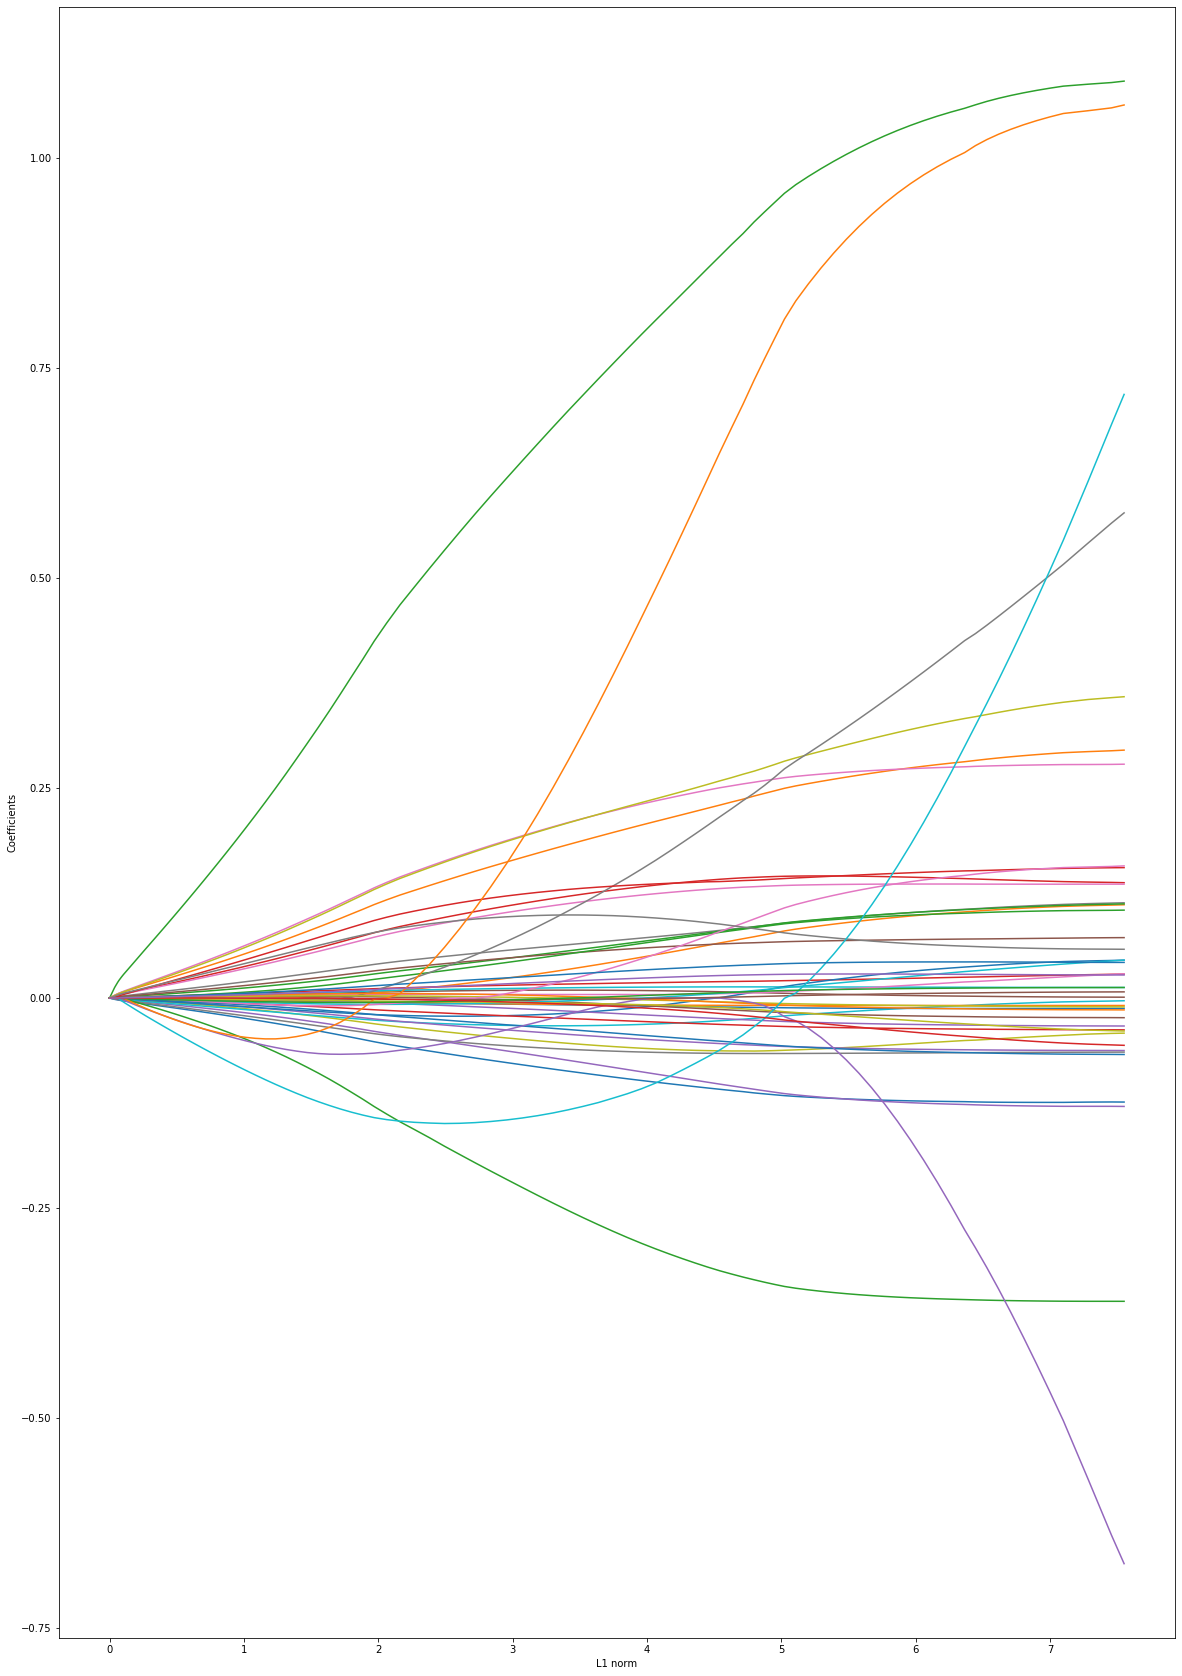

In [46]:
l1_norm = np.sum(np.abs(elnet.coef_path_), axis=0)

plt.figure(figsize=(20,30))
plt.plot(l1_norm, elnet.coef_path_.T)
plt.xlabel('L1 norm')
plt.ylabel('Coefficients');

### Lasso Coefficients and Feature Selection <a class="anchor" id="23"></a>

In [47]:
alphas = 10**np.linspace(.1,-10,100)*0.5
plt.figure(figsize=(20,30))
lasso = Lasso(max_iter=10000)
#lasso = LassoCV(alphas=None, cv=5, max_iter=10000)
coefs = []

for a in alphas*2:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X1), y1)
    coefs.append(lasso.coef_)

<Figure size 1440x2160 with 0 Axes>

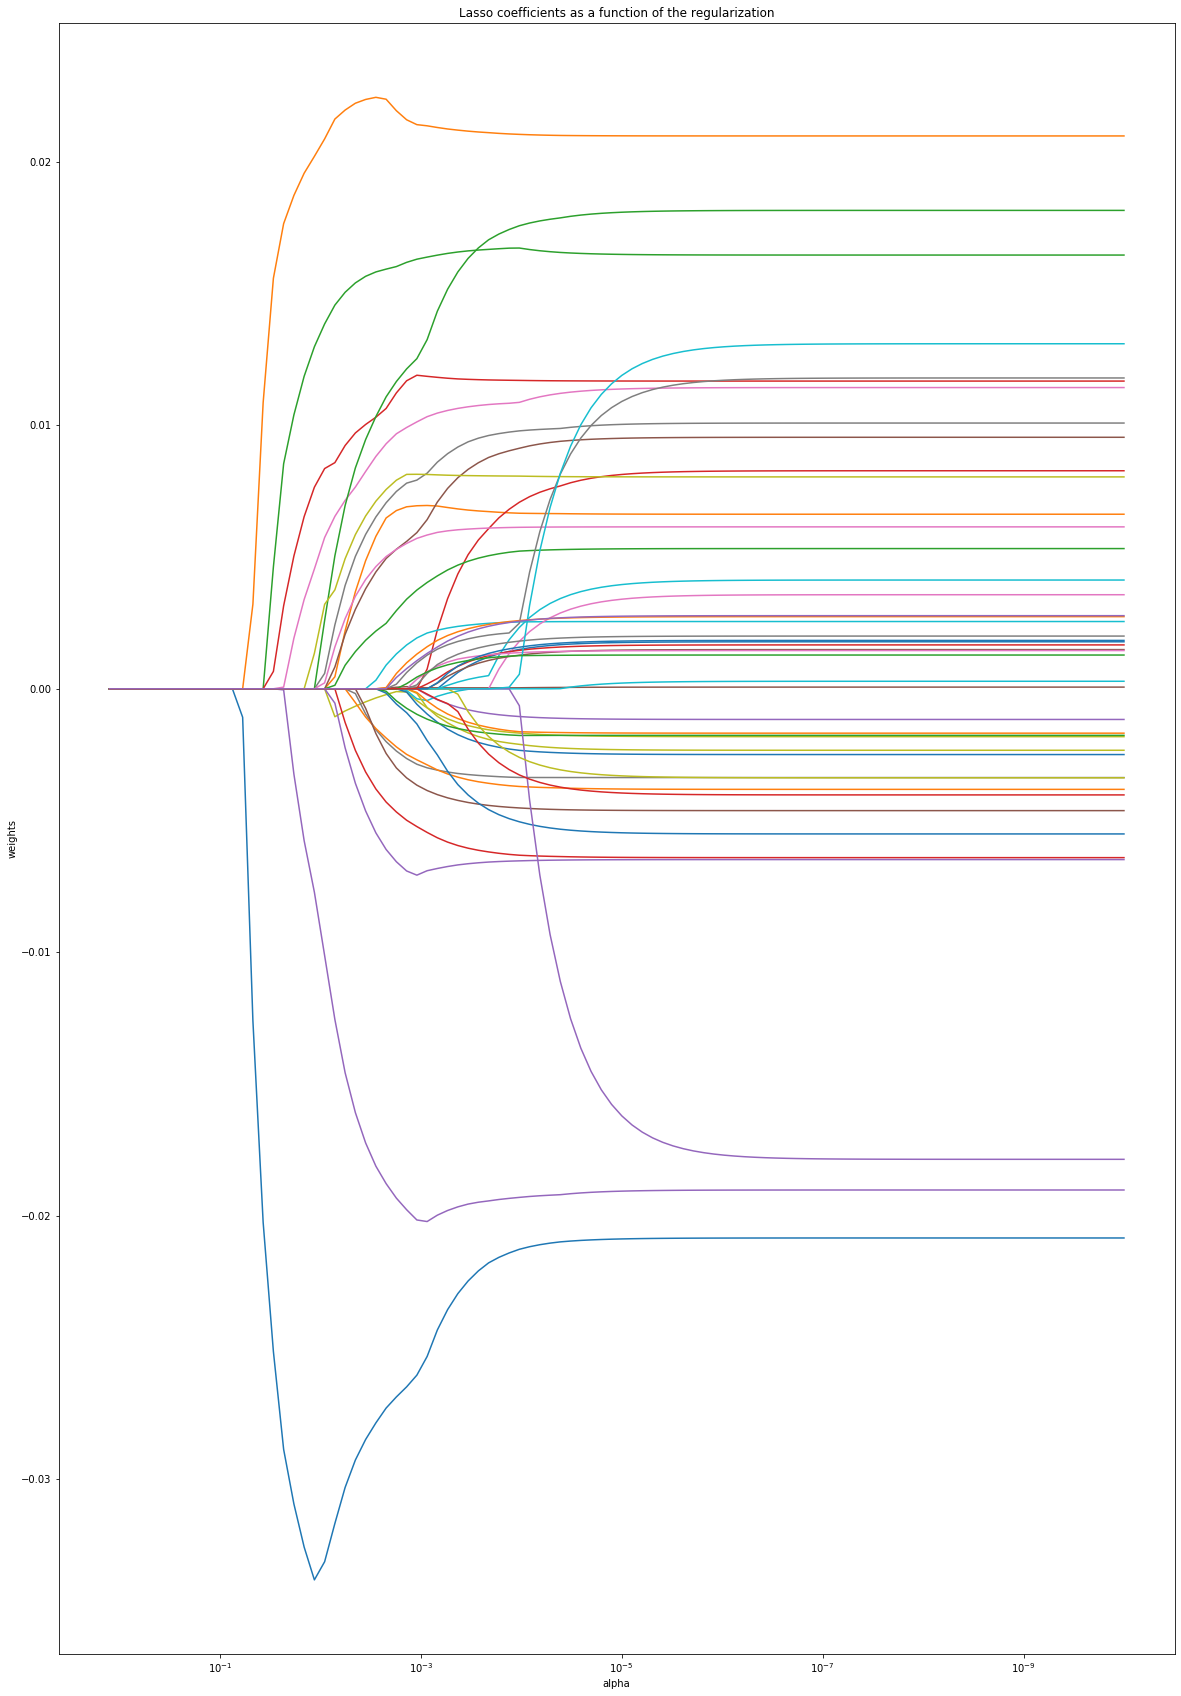

In [48]:
plt.figure(figsize=(20,30))
ax = plt.gca()
ax.plot(alphas*2,coefs)

#plt.plot(coefs,label=[X1.columns])
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis

plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization');

In [49]:
coefs

[array([-0.,  0.,  0.,  0., -0.,  0.,  0.,  0., -0., -0., -0., -0.,  0.,
         0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0., -0., -0.,  0.,
         0., -0.,  0., -0., -0.,  0., -0.,  0., -0., -0., -0.,  0., -0.,
        -0.,  0., -0., -0.,  0.,  0.]),
 array([-0.,  0.,  0.,  0., -0.,  0.,  0.,  0., -0., -0., -0., -0.,  0.,
         0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0., -0., -0.,  0.,
         0., -0.,  0., -0., -0.,  0., -0.,  0., -0., -0., -0.,  0., -0.,
        -0.,  0., -0., -0.,  0.,  0.]),
 array([-0.,  0.,  0.,  0., -0.,  0.,  0.,  0., -0., -0., -0., -0.,  0.,
         0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0., -0., -0.,  0.,
         0., -0.,  0., -0., -0.,  0., -0.,  0., -0., -0., -0.,  0., -0.,
        -0.,  0., -0., -0.,  0.,  0.]),
 array([-0.,  0.,  0.,  0., -0.,  0.,  0.,  0., -0., -0., -0., -0.,  0.,
         0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0., -0., -0.,  0.,
         0., -0.,  0., -0., -0.,  0., -0.,  0., -0., -0., -0.,  0., -0.,
    

In [50]:
alphas

array([6.29462706e-01, 4.97679558e-01, 3.93486286e-01, 3.11106724e-01,
       2.45973996e-01, 1.94477335e-01, 1.53761920e-01, 1.21570608e-01,
       9.61188106e-02, 7.59955541e-02, 6.00852654e-02, 4.75059254e-02,
       3.75601727e-02, 2.96966444e-02, 2.34794098e-02, 1.85638040e-02,
       1.46773203e-02, 1.16045037e-02, 9.17500623e-03, 7.25414389e-03,
       5.73542974e-03, 4.53467077e-03, 3.58530049e-03, 2.83468860e-03,
       2.24122344e-03, 1.77200504e-03, 1.40102134e-03, 1.10770611e-03,
       8.75798804e-04, 6.92443186e-04, 5.47474561e-04, 4.32856299e-04,
       3.42234304e-04, 2.70584763e-04, 2.13935638e-04, 1.69146468e-04,
       1.33734276e-04, 1.05735915e-04, 8.35992397e-05, 6.60970574e-05,
       5.22590997e-05, 4.13182312e-05, 3.26679227e-05, 2.58286268e-05,
       2.04211933e-05, 1.61458500e-05, 1.27655847e-05, 1.00930055e-05,
       7.97995252e-06, 6.30928442e-06, 4.98838430e-06, 3.94402538e-06,
       3.11831152e-06, 2.46546759e-06, 1.94930185e-06, 1.54119962e-06,
      

In [51]:
lassocv = LassoCV(alphas=None, cv=5, max_iter=10000)
lassocv.fit(scale(X1), y1.to_numpy().ravel())

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        max_iter=10000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

#### Need logistic regression with l1 penalty to simulate lasso to use "predict_proba" for a comparable AUC/ROC

In [52]:
lassolog=LogisticRegression(solver='saga',random_state=19,penalty='l1')

In [53]:
lassocv.alpha_

6.04746543148847e-05

In [54]:
lasso_model=lassolog.fit(scale(X1), y1)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [55]:
lasso.set_params(alpha=lassocv.alpha_)
lassoorig=lasso.fit(scale(X1),y1)

In [56]:
s=pd.Series(lasso.coef_, index=X.columns)
s

NEW_EXT_SOURCES_MEAN                      -0.021086
prev_score_mean                            0.021023
buro_score_sum                             0.016620
prev_score_max                             0.011699
external_1_refill                         -0.019242
INTEREST                                   0.000047
buro_score_max                             0.011112
app EXT_SOURCE_1 / DAYS_BIRTH              0.009855
DOWN_PAYMENT                              -0.001739
app EXT_SOURCE_1 * EXT_SOURCE_2            0.000000
NEW_CREDIT_TO_ANNUITY_RATIO               -0.002402
AMT_ANNUITY                                0.006655
app EXT_SOURCE_2 / DAYS_BIRTH              0.017788
DAYS_BIRTH                                 0.007509
LATE_PAYMENT                              -0.001100
app EXT_SOURCE_3 / DAYS_BIRTH              0.009316
CRED_UTIL_2                                0.006139
external_3_refill                         -0.003369
NEW_CREDIT_TO_GOODS_RATIO                  0.008062
DAYS_ID_PUBL

In [57]:
p=s.sort_values(ascending=False)
p

prev_score_mean                            0.021023
app EXT_SOURCE_2 / DAYS_BIRTH              0.017788
buro_score_sum                             0.016620
prev_score_max                             0.011699
buro_score_max                             0.011112
app EXT_SOURCE_1 / DAYS_BIRTH              0.009855
app EXT_SOURCE_3 / DAYS_BIRTH              0.009316
NEW_CREDIT_TO_GOODS_RATIO                  0.008062
DAYS_BIRTH                                 0.007509
AMT_ANNUITY                                0.006655
ACTIVE_AMT_CREDIT_SUM_SUM                  0.006403
CRED_UTIL_2                                0.006139
CLOSED_AMT_CREDIT_SUM_SUM                  0.005824
NEW_ANNUITY_TO_INCOME_RATIO                0.005267
NEW_CAR_TO_BIRTH_RATIO                     0.003089
APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MIN    0.002655
NEW_INC_PER_CHLD                           0.002653
DAYS_ID_PUBLISH                            0.002547
OWN_CAR_AGE                                0.002546
prev_score_s

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

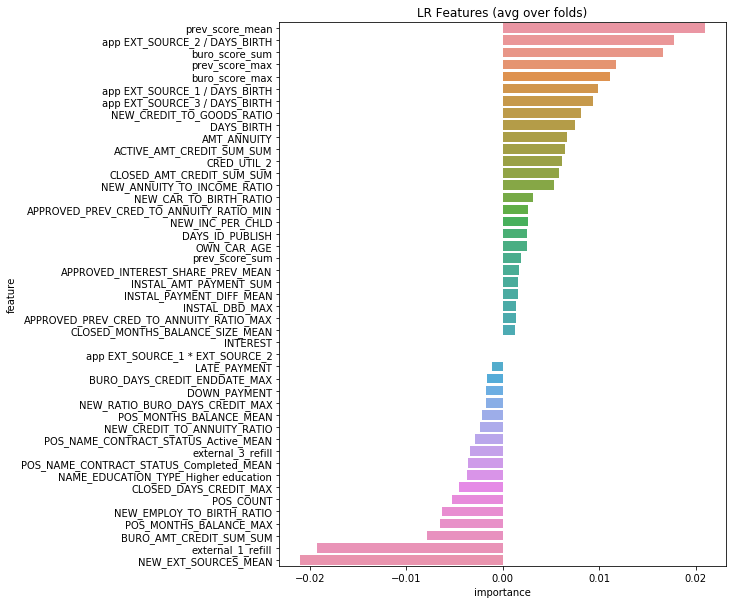

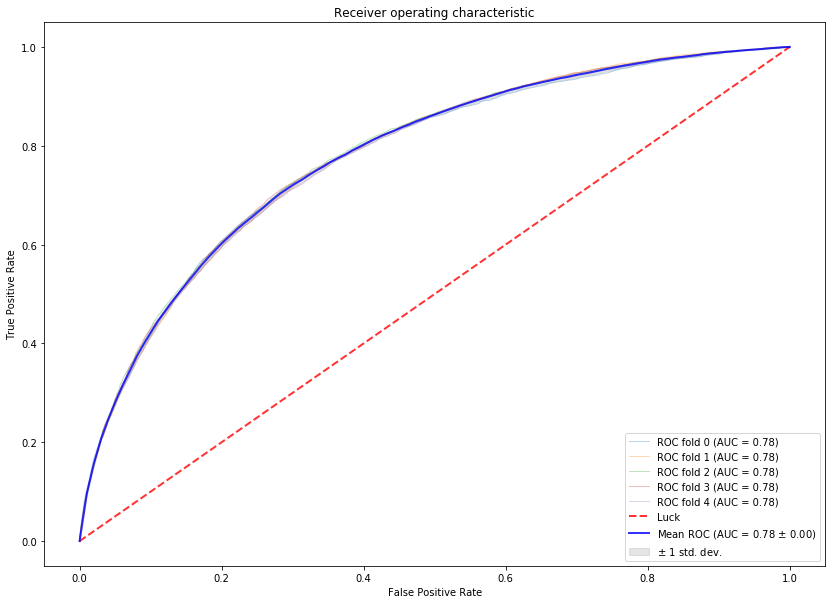

,AUC Train,AUC Test,f1-score
0,0.779686,0.777491,0.524792
1,0.779185,0.778399,0.519859
2,0.778637,0.781553,0.519456
3,0.778773,0.781020,0.522868
4,0.780031,0.776003,0.522203


In [58]:
cv = StratifiedKFold(n_splits=5, random_state=19, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
    
for (train1, test1), i in zip(cv.split(X1, y1), range(5)):
    model=lasso_model.fit(X1.iloc[train1], y1.iloc[train1])
    _, _, auc_score_train = compute_roc_auc(train1)
    y_pred = model.predict(X1.iloc[test1])
    f1_test = f1_score(y1.iloc[test1],y_pred, average='macro',zero_division=1)
    fpr, tpr, auc_score = compute_roc_auc(test1)
    scores.append((auc_score_train, auc_score, f1_test))
    fprs.append(fpr)
    tprs.append(tpr)
    feature_importance_df = pd.DataFrame()
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feature_cols
    fold_importance_df["importance"] = lassoorig.coef_
    
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)


display_importances(feature_importance_df)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test', 'f1-score'])